In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad, simps
from scipy.optimize import curve_fit
from scipy.special import erf
import sympy as sp
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
from astropy.cosmology import Planck18, z_at_value
from astropy import units as u
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM



In [83]:
# ============================================================================
# TELESCOPE SELECTION
# ============================================================================
# Choose telescope: "parkes", "fast", "meerkat_incoherent", or "meerkat_coherent"
# TELESCOPE = "parkes"
# TELESCOPE = "fast"
# TELESCOPE = "meerkat_incoherent"
TELESCOPE = "parkes"
# ============================================================================

# Telescope parameters dictionary
TELESCOPE_PARAMS = {
    "parkes": {
        "D": 320,
        "eta": 0.6,
        "Trec": 25,
        "Tsky": 3,
        "BW": 800e6,
        "nu_cen": 1.4e9,
        "n_comp": 16, # change n_comp
        "n_dishes": 1,  # Single dish
        "n_chan": 2048,  # Single dish
    },
    "fast": {
        "D": 300, # physical size
        "eta": 0.6,
        "Trec": 24,
        "Tsky": 3,
        "BW": 500e6,
        "nu_cen": 1.25e9,
        "n_comp": 16,
        "n_dishes": 1,  # Single dish
    },
    "meerkat_incoherent": {
        "D": 13.5,
        "eta": 0.70, 
        "Trec": 20,   
        "Tsky": 3,
        "BW": 856e6,
        "nu_cen": 1.284e9,
        "n_comp": 16,
        "n_dishes": 64,
        "mode": "incoherent",
        "description": "MeerKAT array - incoherent beam (power addition)",
    },
    "meerkat_coherent": {
        "D": 13.5,
        "eta": 0.70,  
        "Trec": 20,   
        "Tsky": 3,
        "BW": 856e6,
        "nu_cen": 1.284e9,
        "n_comp": 16,
        "n_dishes": 64,
        "mode": "coherent",
        "description": "MeerKAT array - coherent beam (phase alignment)",
    },
}



In [84]:

# Load selected telescope parameters
if TELESCOPE.lower() not in TELESCOPE_PARAMS:
    raise ValueError(f"Telescope must be one of: {list(TELESCOPE_PARAMS.keys())}")

params = TELESCOPE_PARAMS[TELESCOPE.lower()]

# Physical constants
k = 1.38e-23  # Boltzmann constant
c = 3.0e8     # Speed of light

# Extract parameters
D = params["D"]
eta = params["eta"]
n_dishes = params.get("n_dishes", 1)
mode = params.get("mode", "single")


# Calculate array gain factor based on beamforming mode
if mode == "coherent":
    array_gain_factor = n_dishes
    # gain_description = f"Coherent ({n_dishes}× - phase aligned)"
    
elif mode == "incoherent":
    array_gain_factor = np.sqrt(n_dishes)
    # gain_description = f"Incoherent (√{n_dishes} × {coherence_loss} = {array_gain_factor:.2f}×)"
    
else:
    # Single dish (Parkes, FAST)
    array_gain_factor = 1.0
    gain_description = "Single dish"

# Apply array gain to system sensitivity
G0 = np.pi * D*D/4 * eta/2.0/k*1e-26 * array_gain_factor
nu0 = 1.4e9  # reference frequency in Hz
Np = 2
Trec = params["Trec"]
Tsky = params["Tsky"]
BW = params["BW"]
n_comp = params["n_comp"]
BW_comp = BW / n_comp
n_chan = params["n_chan"] # Mhz
BW_chan = BW / n_chan
nu_cen = params["nu_cen"]
nu_min = nu_cen - BW / 2  # Calculate nu_min
nu_max = nu_cen + BW / 2  # Calculate nu_max
nu_array = np.linspace(nu_min, nu_max, n_comp)



In [85]:
def gaussian_beam_gain(nu, G0, theta, D, c):
    """
    Gaussian beam gain with frequency dependence
    G(ν) = G₀ × exp[−θ²ν²D²×2.355²/(2×1.22²×c²)]

    Returns:
    Gain (K/Jy)
    """
    # Exponent coefficient
    coeff = (theta**2 * D**2 * 2.355**2) / (2 * 1.22**2 * c**2)
    return G0 * np.exp(-coeff * nu**2)

def SNR(S,t,G,BW,Np,Trec,Tsky):
    return(S*G*np.sqrt(BW*t*Np)/(Trec+Tsky))





Intrinsic spectral distribution: Uniform

In [86]:
# FRB Parameters
# lum = 1.e+26  # Radio luminosity in W/Hz
lum = 1e15 # mJy kpc^2 assumed from paper
theta_min = 0.0
theta_max = 2*1.22*c/64/nu_min # please note here
t = 0.001
wi = 0.001  # intrinsic width in seconds

results_by_shell = []
all_alpha_intrinsic = []
all_alpha_inferred = []
all_snr_coherent = []
all_detected_count = []
flux_density = []
all_theta = []  
all_dm = [] 
# cosmology 
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
np.random.seed(42)
# Redshift parameters
z_array = np.arange(0.01, 5, 0.01)
dz = 0.01
area = 1.  # Area of sky in square degrees



In [87]:
freq_powers_scatter = np.array([(nu_min * BW_comp * (i+1))**(-4) for i in range(n_comp)])

for z in z_array:
    zmin = z - 0.5 * dz
    zmax = z + 0.5 * dz
    
    # Calculate SFR and volumes
    psi = 0.015 * ((1+z)**2.7) / (1 + ((1+z)/2.9)**5.6)
    dvol = (cosmo.comoving_volume(zmax).value-cosmo.comoving_volume(zmin).value)*(area/(4.*np.pi*((180./np.pi)**2)))
    
    t1 = cosmo.age(zmax).value
    t2 = cosmo.age(zmin).value
    dt = (t2 - t1) * 1.e+9
    fscale = 1e-8
    # Number of FRBs in this shell
    nfrb_shell = psi * dvol * dt * fscale
    # nfrb_shell =   0.015 *dvol * dt * fscale
    nfrb_shell = max(nfrb_shell, 1)  # Set minimum to 1
    nfrb_shell = int(np.round(nfrb_shell))
    # print (nfrb_shell)
    # Luminosity distance
    dl = cosmo.luminosity_distance(z).value
    dl *= 3.086e+22  # Convert to metres
    
    # Generate FRBs in this shell
    shell_alpha_intrinsic = []
    shell_alpha_inferred = []
    shell_snr_coherent = []
    shell_theta = [] 
    shell_detected = 0
    
    for i in range(nfrb_shell):
        # Generate FRB properties
        # alpha_intrinsic = np.random.uniform(-4, 0)
        alpha_intrinsic = -2
        shell_alpha_intrinsic.append(alpha_intrinsic)
        
        
        DM = 1000 * z  # Simplified DM-z relation
        all_dm.append(DM)
        wi_z = wi * (1 + z)
        # width
        w_DM = 8.3e3*BW_chan*DM/nu_cen**3 # ms
        w_scatter_comp = 1.9e-7 * (DM**1.5) * (1 + (DM**3) * 3.55e-5) * 3 * freq_powers_scatter
        w_scatter = np.sqrt(np.sum(w_scatter_comp**2) / len(w_scatter_comp))
        w_sampling = 0.064 # ms

        # Total observed width # ms
        w_obs = np.sqrt(wi_z**2 + w_DM**2 + w_scatter**2 + w_sampling**2)
        

        # Flux at reference frequency (from luminosity)
        # Luminosity distance in Mpc
        dl = cosmo.luminosity_distance(z).value
        dl *= 1000 # Mpc to Kpc
 

        S0_frb = lum/((dl**2)*((1+z)**(-1-alpha_intrinsic)))*np.sqrt(wi_z/w_obs)

        flux_density.append(S0_frb)
        
        # Angular offset
        theta_frb = theta_max * np.sqrt(np.random.random())
        theta_frb = np.abs(theta_frb)  # Ensure positive
        shell_theta.append(theta_frb)
        
        # STAGE 1: Quick SNR check at reference frequency
        S_nu_low = S0_frb * (nu_min / nu0)**alpha_intrinsic
        G_max = gaussian_beam_gain(nu0, G0, 0, D, 3.0e8)
        snr_max = SNR(S_nu_low, t, G_max, BW, Np, Trec, Tsky)
        
        if snr_max < 10:
            shell_alpha_inferred.append(np.nan)
            shell_snr_coherent.append(np.nan)
            continue
        
        # STAGE 2: Calculate SNR spectrum (vectorized)
        S_nu = S0_frb * (nu_array / nu0)**alpha_intrinsic
        G_nu = gaussian_beam_gain(nu_array, G0, theta_frb, D, 3.0e8)
        snr_spectrum = SNR(S_nu, t, G_nu, BW_comp, Np, Trec, Tsky)
        
        # Coherent SNR
        snr_coherent = np.sqrt(np.sum(snr_spectrum**2) / len(snr_spectrum))
        shell_snr_coherent.append(snr_coherent)
        
        # STAGE 3: Detection and spectral index fitting
        is_detected = snr_coherent > 10
        
        if is_detected:
            shell_detected += 1
            try:
                # Robust fitting in log-log space
                # 1. Normalize frequency to avoid huge numbers (e.g., 1.4e9^5)
                # 2. Use linear regression (polyfit) instead of non-linear curve_fit
                
                log_nu = np.log10(nu_array / nu0)
                log_snr = np.log10(snr_spectrum)
                
                # Fit: log(SNR) = alpha * log(nu/nu0) + constant
                # slope [0] is the spectral index
                slope, intercept = np.polyfit(log_nu, log_snr, 1)
                
                shell_alpha_inferred.append(slope)
            except:
                shell_alpha_inferred.append(np.nan)
        else:
            shell_alpha_inferred.append(np.nan)
    # Store results for this shell
    shell_alpha_intrinsic = np.array(shell_alpha_intrinsic)
    shell_alpha_inferred = np.array(shell_alpha_inferred)
    shell_snr_coherent = np.array(shell_snr_coherent)
    
    results_by_shell.append({
        'z': z,
        'nfrb_shell': nfrb_shell,
        'alpha_intrinsic': shell_alpha_intrinsic,
        'alpha_inferred': shell_alpha_inferred[~np.isnan(shell_alpha_inferred)],
        'snr_coherent': shell_snr_coherent,
        'detected': shell_detected,
        'psi': psi,
        'dvol': dvol,
        'dt': dt
    })
    
    # Accumulate for global statistics
    all_alpha_intrinsic.extend(shell_alpha_intrinsic)
    
    # FIX: Keep NaNs to maintain array alignment with intrinsic array
    all_alpha_inferred.extend(shell_alpha_inferred) 
    all_snr_coherent.extend(shell_snr_coherent)
    all_theta.extend(shell_theta)
    all_detected_count.append(shell_detected)

all_alpha_intrinsic = np.array(all_alpha_intrinsic)
all_alpha_inferred = np.array(all_alpha_inferred)
all_snr_coherent = np.array(all_snr_coherent)
all_detected_count = np.array(all_detected_count)
all_theta = np.array(all_theta)
flux_density = np.array(flux_density)
all_dm = np.array(all_dm)

# print(f"Total FRBs generated: {sum([r['nfrb_shell'] for r in results_by_shell])}")
# print(f"Total detected: {np.sum(all_detected_count)}")
# print(f"Mean intrinsic α: {np.mean(all_alpha_intrinsic):.3f}")
# print(f"Mean inferred α: {np.mean(all_alpha_inferred):.3f}")

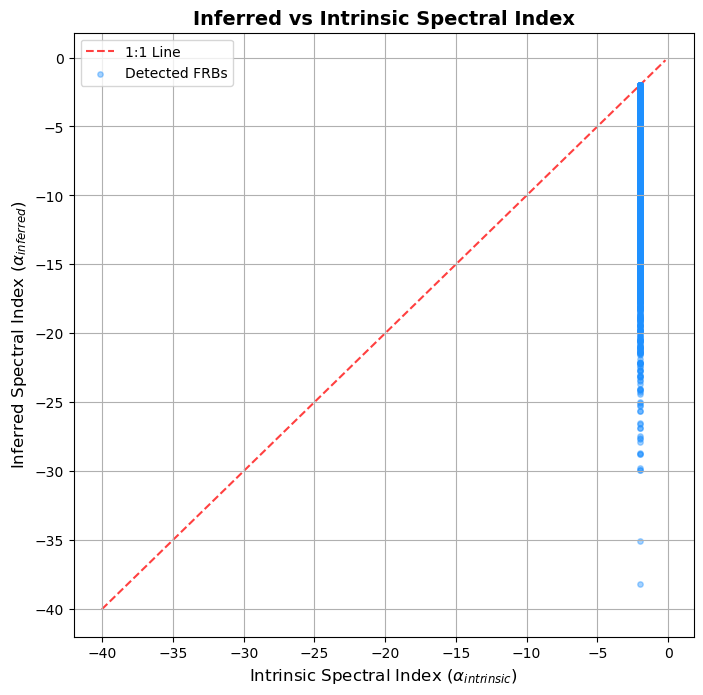

In [88]:
# Create mask for detected FRBs
valid_mask = ~np.isnan(all_alpha_inferred)

# Filter both arrays to include only detected FRBs
# Note: all_alpha_intrinsic is sliced to match the length of all_alpha_inferred if needed
alpha_intrinsic_detected = all_alpha_intrinsic[:len(all_alpha_inferred)][valid_mask]
alpha_inferred_detected = all_alpha_inferred[valid_mask]

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(alpha_intrinsic_detected, alpha_inferred_detected, alpha=0.4, s=15, color='dodgerblue', label='Detected FRBs')

# Add 1:1 reference line
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='1:1 Line')

plt.xlabel('Intrinsic Spectral Index ($\\alpha_{intrinsic}$)', fontsize=12)
plt.ylabel('Inferred Spectral Index ($\\alpha_{inferred}$)', fontsize=12)
plt.title('Inferred vs Intrinsic Spectral Index', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)

LinAlgError: singular matrix

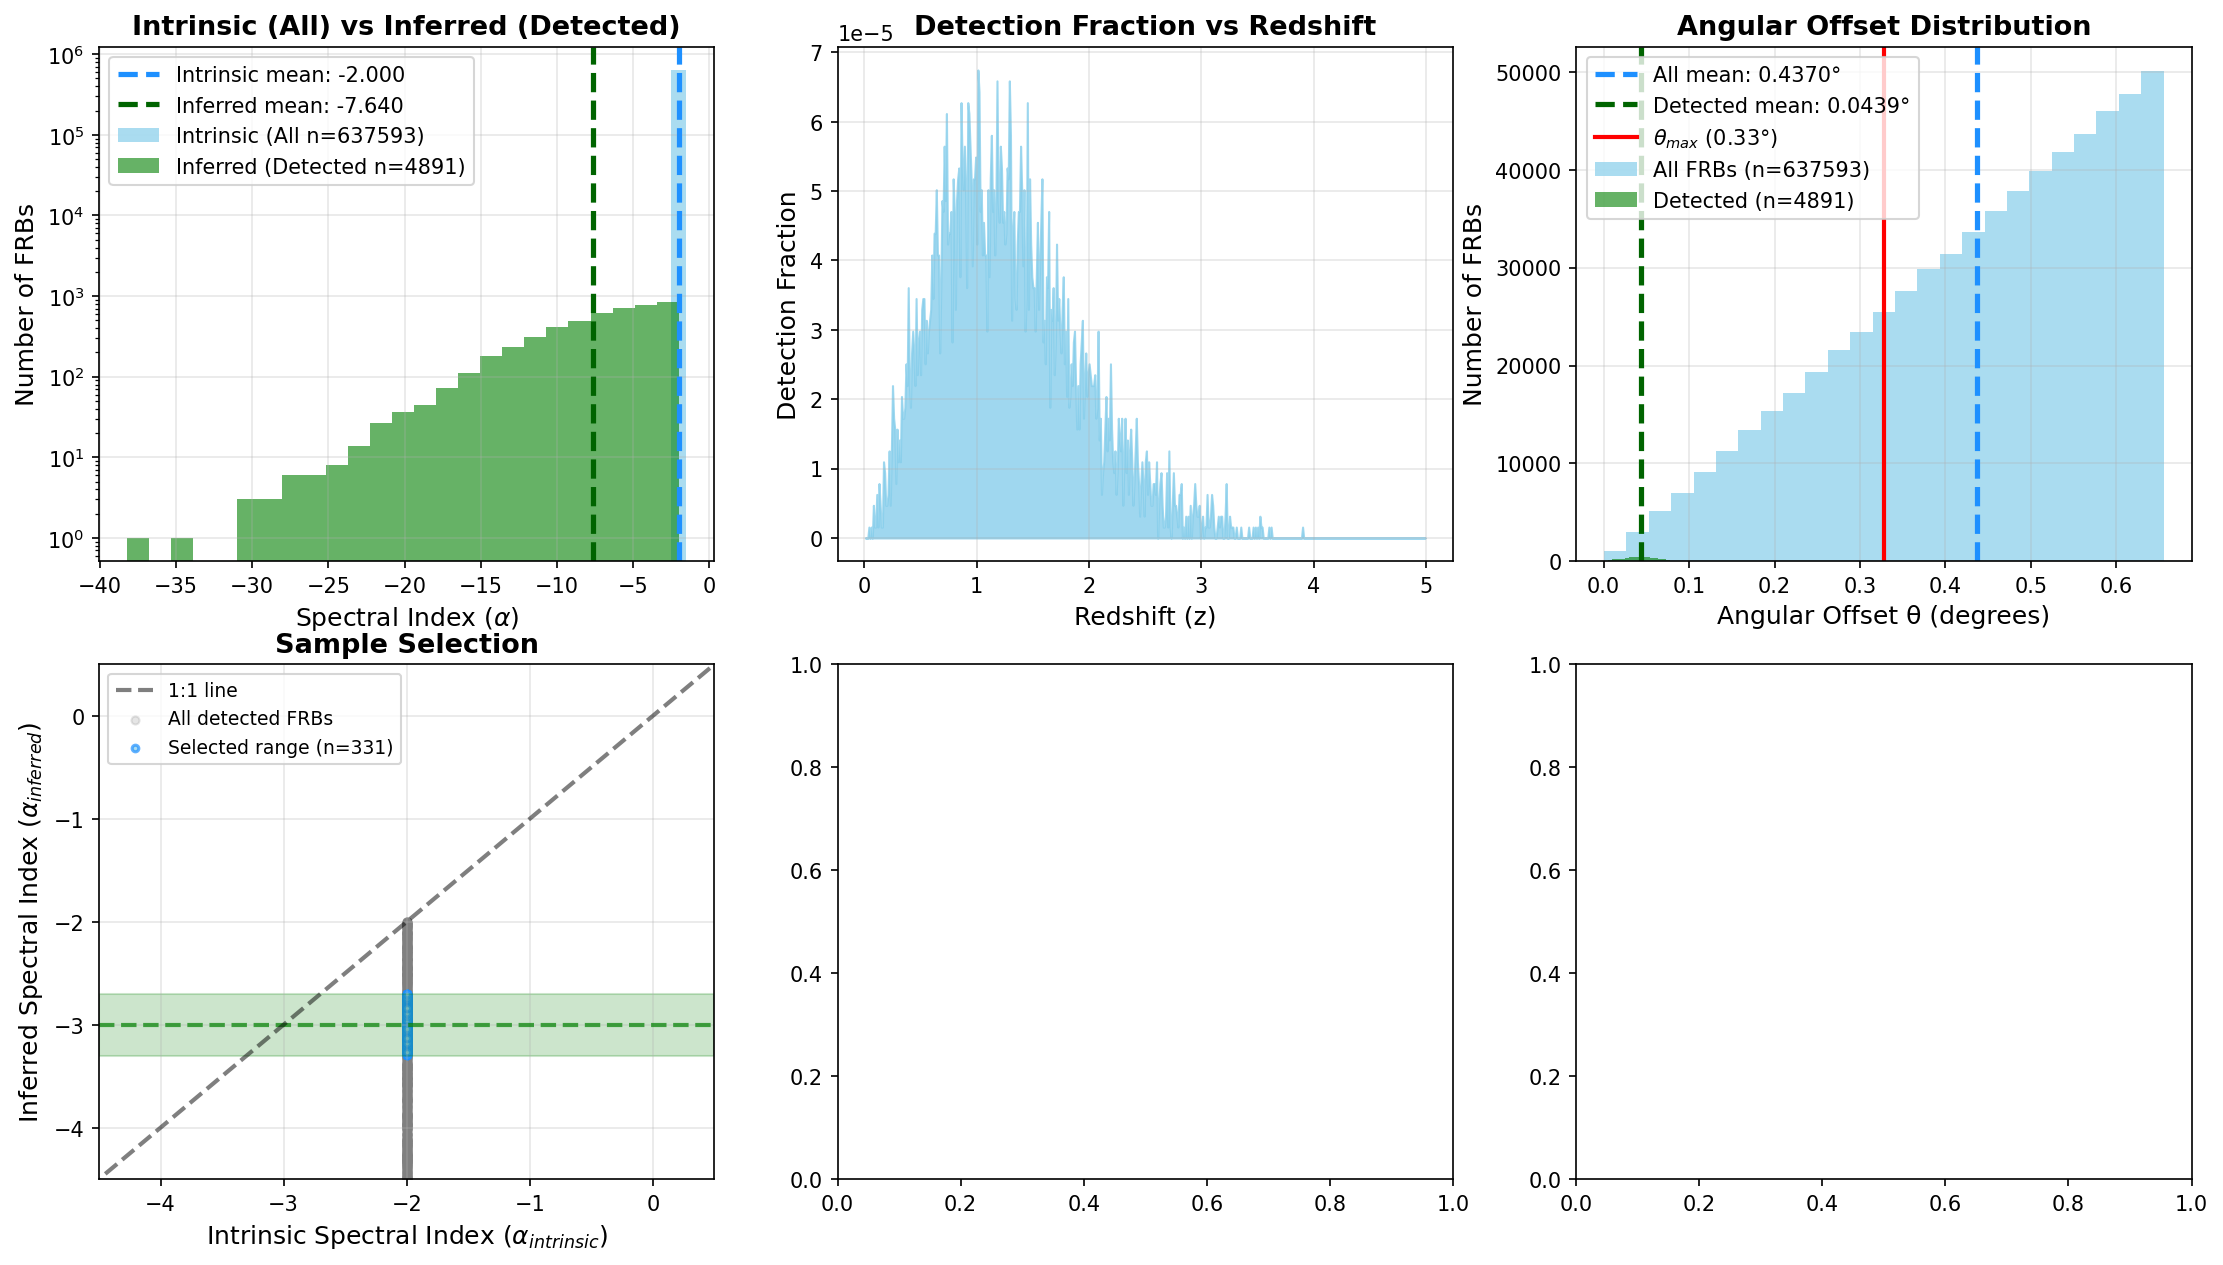

In [92]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=150)

# Plot 1: Combined Spectral Index Distributions (DETECTED ONLY)
ax = axes[0, 0]

# Create mask for detected FRBs with valid inferred alpha
valid_mask = ~np.isnan(all_alpha_inferred)
# Intrinsic: Plot ALL FRBs (to show full population)
ax.hist(all_alpha_intrinsic, bins=1, alpha=0.7, color='skyblue', edgecolor='none', 
        label=f'Intrinsic (All n={len(all_alpha_intrinsic)})')
ax.axvline(np.mean(all_alpha_intrinsic), color='dodgerblue', linestyle='--', linewidth=2.5, 
           label=f'Intrinsic mean: {np.mean(all_alpha_intrinsic):.3f}')

# Inferred: Plot DETECTED FRBs only
alpha_inferred_detected = all_alpha_inferred[valid_mask]
ax.hist(alpha_inferred_detected, bins=25, alpha=0.6, color='green', edgecolor='none', 
        label=f'Inferred (Detected n={len(alpha_inferred_detected)})')
ax.axvline(np.mean(alpha_inferred_detected), color='darkgreen', linestyle='--', linewidth=2.5, 
           label=f'Inferred mean: {np.mean(alpha_inferred_detected):.3f}')

ax.set_xlabel('Spectral Index ($\\alpha$)', fontsize=12)
ax.set_ylabel('Number of FRBs', fontsize=12)
ax.set_title('Intrinsic (All) vs Inferred (Detected)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 2: Detection Rate by Redshift
ax = axes[0, 1]
z_values = np.array([r['z'] for r in results_by_shell])
detected_counts = np.array([r['detected'] for r in results_by_shell])
total_counts = sum([r['nfrb_shell'] for r in results_by_shell])
# Calculate fraction (0 to 1) instead of percentage
detection_fraction = np.where(total_counts > 0, detected_counts / total_counts, 0)

# ax.plot(z_values, detection_fraction, 'o-', color='dodgerblue', linewidth=2, markersize=6)
ax.fill_between(z_values, detection_fraction, alpha=0.8, color='skyblue')
ax.set_xlabel('Redshift (z)', fontsize=12)
ax.set_ylabel('Detection Fraction', fontsize=12)
ax.set_title('Detection Fraction vs Redshift', fontsize=13, fontweight='bold')
# Force scientific notation on Y axis
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(True, alpha=0.3)

# Plot 3: Angular offset distribution
# Plot 3: Angular offset distribution
ax = axes[0, 2]

# Create mask for detected FRBs with valid inferred alpha
valid_mask = ~np.isnan(all_alpha_inferred)

# Convert all theta to degrees
all_theta_deg = np.degrees(all_theta)
theta_detected_deg = all_theta_deg[valid_mask]

ax.hist(all_theta_deg, bins=25, alpha=0.7, color='skyblue', edgecolor='none', 
        label=f'All FRBs (n={len(all_theta_deg)})')
ax.axvline(np.mean(all_theta_deg), color='dodgerblue', linestyle='--', linewidth=2.5, 
           label=f'All mean: {np.mean(all_theta_deg):.4f}°')

ax.hist(theta_detected_deg, bins=25, alpha=0.6, color='green', edgecolor='none', 
        label=f'Detected (n={len(theta_detected_deg)})')
ax.axvline(np.mean(theta_detected_deg), color='darkgreen', linestyle='--', linewidth=2.5, 
           label=f'Detected mean: {np.mean(theta_detected_deg):.4f}°')

# Add theta_max line
ax.axvline(np.degrees(theta_max/2), color='red', linestyle='-', linewidth=2, 
           label=f'$\\theta_{{max}}$ ({np.degrees(theta_max/2):.2f}°)')

ax.set_xlabel('Angular Offset θ (degrees)', fontsize=12)
ax.set_ylabel('Number of FRBs', fontsize=12)
ax.set_title('Angular Offset Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Scatter - Intrinsic vs Inferred Spectral Index
ax = axes[1, 0]
# Create mask for detected FRBs with valid inferred alpha
valid_mask = ~np.isnan(all_alpha_inferred)
alpha_intrinsic_valid = all_alpha_intrinsic[:len(all_alpha_inferred)][valid_mask]
alpha_inferred_valid = all_alpha_inferred[valid_mask]

alpha_inferred_target = -3.0
delta_alpha = 0.3
mask_range = (alpha_inferred_valid >= alpha_inferred_target - delta_alpha) & \
             (alpha_inferred_valid <= alpha_inferred_target + delta_alpha)

intrinsic_conditional = alpha_intrinsic_valid[mask_range]

ax.scatter(alpha_intrinsic_valid, alpha_inferred_valid, alpha=0.2, s=15, 
          color='gray', label='All detected FRBs')
ax.scatter(intrinsic_conditional, alpha_inferred_valid[mask_range], alpha=0.7, s=10, 
          color='skyblue', edgecolor='dodgerblue', linewidth=1.5, 
          label=f'Selected range (n={np.sum(mask_range)})')
ax.axhspan(alpha_inferred_target - delta_alpha, alpha_inferred_target + delta_alpha, 
          alpha=0.2, color='green')
ax.axhline(alpha_inferred_target, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.plot([-5, 5], [-5, 5], 'k--', linewidth=2, label='1:1 line', alpha=0.5)

ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=12)
ax.set_ylabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=12)
ax.set_title('Sample Selection', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-4.5, 0.5])
ax.set_ylim([-4.5, 0.5])

# Plot 5: Conditional PDF
ax = axes[1, 1]
if len(intrinsic_conditional) > 2:
    kde_conditional = gaussian_kde(intrinsic_conditional)
    alpha_range = np.linspace(intrinsic_conditional.min() - 0.5, 
                               intrinsic_conditional.max() + 0.5, 200)
    pdf_conditional = kde_conditional(alpha_range)
    
    ax.fill_between(alpha_range, pdf_conditional, alpha=0.7, color='skyblue')
    ax.plot(alpha_range, pdf_conditional, 'dodgerblue', linewidth=2)
    ax.axvline(np.mean(intrinsic_conditional), color='dodgerblue', linestyle='--', linewidth=2.5, 
               label=f'Mean: {np.mean(intrinsic_conditional):.3f}')
    ax.axvspan(alpha_inferred_target - delta_alpha, alpha_inferred_target + delta_alpha, 
               alpha=0.2, color='green', label=f'$\\alpha_{{inferred}}$ ∈ [{alpha_inferred_target - delta_alpha:.2f}, {alpha_inferred_target + delta_alpha:.2f}]')
    ax.axvline(alpha_inferred_target, color='green', linestyle='--', linewidth=2.5)
    
    ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.set_title('Conditional PDF', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Plot 6: SNR vs Inferred Spectral Index (Colored by Theta)
ax = axes[1, 2]

# Get corresponding data for detected FRBs
snr_detected = all_snr_coherent[valid_mask]
theta_detected = np.degrees(all_theta[valid_mask])

scatter = ax.scatter(alpha_inferred_detected, snr_detected, 
                     c=theta_detected, cmap='viridis', 
                     alpha=0.6, s=30, edgecolor='black', linewidth=0.5)

ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=12)
ax.set_ylabel('SNR (Coherent)', fontsize=12)
ax.set_title('SNR vs Inferred Spectral Index', fontsize=13, fontweight='bold')
ax.set_yscale('log')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Angular Offset θ (degrees)', fontsize=10)

ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

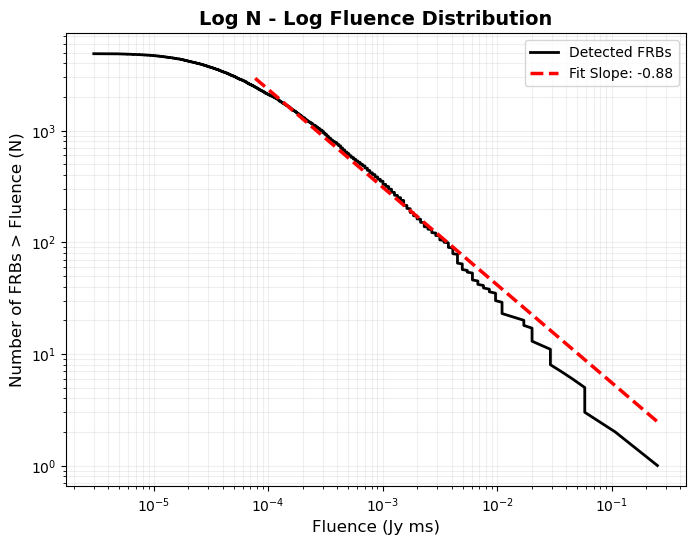

In [93]:
z_approx = all_dm / 1000.0
wi_z_all = wi * (1 + z_approx)
w_DM_all = 8.3e3 * BW_chan * all_dm / nu_cen**3

# Scattering width reconstruction
# Calculate the frequency-dependent factor once (same as in loop)
freq_factor = np.sqrt(np.mean(freq_powers_scatter**2))
# Calculate the DM-dependent factor
scatter_dm_factor = 1.9e-7 * (all_dm**1.5) * (1 + (all_dm**3) * 3.55e-5) * 3
w_scatter_all = scatter_dm_factor * freq_factor

w_sampling = 0.064
w_obs_all = np.sqrt(wi_z_all**2 + w_DM_all**2 + w_scatter_all**2 + w_sampling**2)

# Calculate Fluence = Flux * Width
# flux_density is in mJy (based on lum=1e15 mJy kpc^2)
# w_obs_all is in ms
# Fluence in Jy ms = (mJy * ms) / 1000
fluence_all_jy_ms = (flux_density * w_obs_all) / 1000.0

# Filter for detected FRBs
detected_mask = ~np.isnan(all_alpha_inferred)
fluence_detected = fluence_all_jy_ms[detected_mask]

# Plot Log N - Log Fluence (Cumulative Distribution)
plt.figure(figsize=(8, 6), dpi=100)

# Sort fluence for cumulative calculation
sorted_fluence = np.sort(fluence_detected)
# N(>F) - Number of FRBs with fluence greater than F
y_vals = np.arange(len(sorted_fluence), 0, -1)

plt.plot(sorted_fluence, y_vals, 'k-', linewidth=2, label='Detected FRBs')

 #--- FIT SLOPE ---
# Fit to the high-fluence tail (e.g., top 50%) to avoid sensitivity rolloff at low fluence
cutoff_index = int(len(sorted_fluence) * 0.5)


    # Select the tail
fluence_tail = sorted_fluence[cutoff_index:]
y_tail = y_vals[cutoff_index:]

# Fit in log-log space: log(N) = slope * log(S) + intercept
log_S = np.log10(fluence_tail)
log_N = np.log10(y_tail)

slope, intercept = np.polyfit(log_S, log_N, 1)

# Generate line for plotting
fit_y = 10**(intercept + slope * log_S)

plt.plot(fluence_tail, fit_y, 'r--', linewidth=2.5, label=f'Fit Slope: {slope:.2f}')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Fluence (Jy ms)', fontsize=12)
plt.ylabel('Number of FRBs > Fluence (N)', fontsize=12)
plt.title('Log N - Log Fluence Distribution', fontsize=14, fontweight='bold')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()



In [ ]:
n_detected_low_z = sum(r['detected'] for r in results_by_shell if r['z'] < 1.0)
n_detected_high_z = sum(r['detected'] for r in results_by_shell if r['z'] > 1.0)

print(f"Detected FRBs with z < 1: {n_detected_low_z}")
print(f"Detected FRBs with z > 1: {n_detected_high_z}")
print(f"Ratio (Low/High): {n_detected_low_z/n_detected_high_z:.2f}")# filepath: /Users/xuziying/Desktop/VScode/FRB_population/spectral_index_flat_3D_z.ipynb


Detected FRBs with z < 1: 1800
Detected FRBs with z > 1: 3064
Ratio (Low/High): 0.59


In [ ]:
n_detected_low_z = sum(r['detected'] for r in results_by_shell if r['z'] < 2.0)
n_detected_high_z = sum(r['detected'] for r in results_by_shell if r['z'] > 2.0)

print(f"Detected FRBs with z < 2: {n_detected_low_z}")
print(f"Detected FRBs with z > 2: {n_detected_high_z}")
print(f"Ratio (Low/High): {n_detected_low_z/n_detected_high_z:.2f}")# filepath: /Users/xuziying/Desktop/VScode/FRB_population/spectral_index_flat_3D_z.ipynb

Detected FRBs with z < 2: 4244
Detected FRBs with z > 2: 631
Ratio (Low/High): 6.73


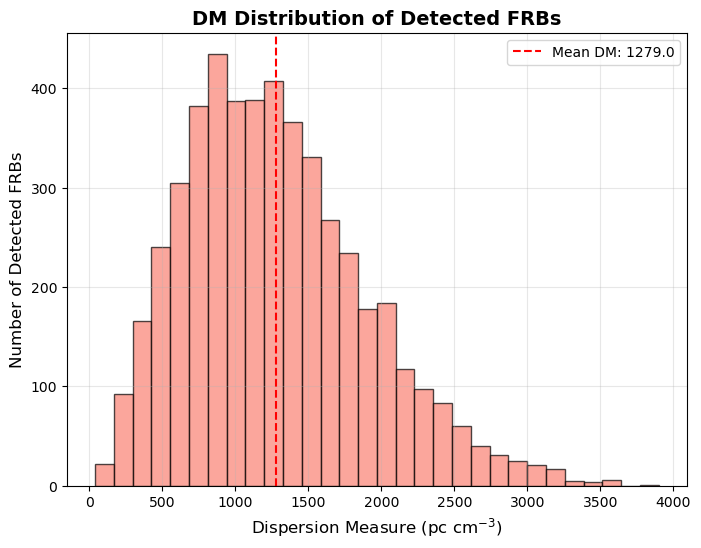

In [ ]:
valid_mask = ~np.isnan(all_alpha_inferred)
dm_detected = all_dm[valid_mask]

plt.figure(figsize=(8, 6), dpi=100)
plt.hist(dm_detected, bins=30, color='salmon', alpha=0.7, edgecolor='black')
plt.axvline(np.mean(dm_detected), color='red', linestyle='--', label=f'Mean DM: {np.mean(dm_detected):.1f}')

plt.xlabel('Dispersion Measure (pc cm$^{-3}$)', fontsize=12)
plt.ylabel('Number of Detected FRBs', fontsize=12)
plt.title('DM Distribution of Detected FRBs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
np.save('dm_detected_320m.npy', dm_detected)


Instrinsic spectral index distribution: Gaussian
